<a href="https://colab.research.google.com/github/khoivan88/upwork-north-country-fire-image-scraping/blob/main/Content_Based_Intelligent_Cropping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Square pegs don't fit in round holes, but what if you have power tools?

Digital images often don't fit where we want them: advertisements, social networks, and printers all require that images be a specific _aspect ratio_ (i.e., the ratio of the image's width to height). Take [Facebook ads](https://www.facebook.com/business/help/103816146375741) for example: different aspect ratios are required depending on what kind of ad you wish to run. This is a large pain point for marketers: each piece of content must be manually cropped to fit the aspect ratio of the channel. Typically, images are either padded with white pixels (thus wasting valuable screen real estate) or arbitrarily cropped (possibly degrading the content).

But it doesn't have to be this way! In this post, we present a technique that we use for *intelligent cropping*: a fully automatic method that preserves the image's content. We've included some example code so you can explore on your own, and some real-world examples from Curalate's products.

The following illustrates our approach:
![](./overview.png)

* The input to the algorithm is an image and a desired aspect ratio.
* First, we use a variety of techniques to detect different types of content in the image. Each technique results in a number of *content rectangles* that are assigned a value score.
* Second, we select the optimal region of the image as that which contains the content rectangles with the higest cumulative score.
* Finally, we crop the input image to the optimal region.

The result is a cropped image of the desired aspect ratio fully containing the content in the image.

## Prerequisites
To run these examples for yourself, you'll need Python 2 with OpenCV, NumPy, and matplotlib installed. The images used for examples in this post may be downloaded [here](/assets/2015-11-19-IntelligentCropping/exampleImages.zip). This entire post is also available as a [python notebook](/assets/2015-11-19-IntelligentCropping/Content%20Based%20Intelligent%20Cropping.ipynb) if you want to take it for a spin.

To start off, let's load an image we'd like to use:

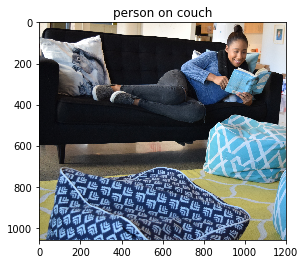

In [1]:
import cv2
import urllib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# def showImage(img):
#     plt.axis('off')
#     plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def showImage(title, image):
    # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()
 
img = cv2.imread("input.jpg")
showImage('person on couch', img)

Let's assume we're creating a Facebook ad to drive traffic to our website. The [recommended resolution](https://www.facebook.com/business/help/103816146375741) is `1200x628` for target aspect ratio of `1.91`.

The naive approach would just crop the center of the image:

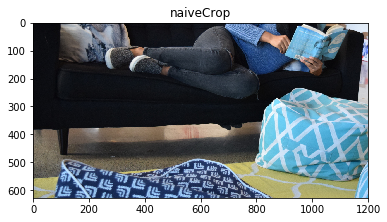

In [20]:
desiredAspectRatio = 1200 / float(628)
newHeight = img.shape[1] / desiredAspectRatio
start = img.shape[0] / 2 - newHeight / 2
naiveCrop = img[int(start):int(start + newHeight), :]
showImage('naiveCrop', naiveCrop)

Ugh. I wouldn't click on that. Let's do something intelligent!

# Identifying Content in Images
Our first task is to detect different content in the image. Object detection is still an active area of research, though [recent advances](http://arxiv.org/abs/1311.2524) have started to make it feasible in many applications. Here we explore a few simple techniques that are built into OpenCV but you can use any detector you like.

## Face Detection
If an image contains a face, it's likely that the person is a key element in the image. Fortunately, face detection is a common task in computer vision:

In [10]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
faceRegions = cascade.detectMultiScale(gray, minNeighbors=7, scaleFactor=1.1)

The result is a numpy array of rectangles containing the faces:

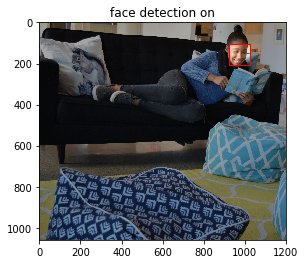

In [11]:
def drawRegions(source, res, regions, color=(0, 0, 255), size=4):
    for (x, y, w, h) in regions:
        res[y: y + h, x: x + w] = source[y: y + h, x: x + w]
        cv2.rectangle(res, (x, y), (x + w, y + h), color, size)
    return res
faded = (img * 0.65).astype(np.uint8)

showImage('face detection on', drawRegions(img, faded.copy(), faceRegions))

## Interest Points
Sometimes, we don't know what we're looking for in an image. Low-level image characteristics, however, often correspond to the interesting area of images. There are many common techniques for identifying interesting areas of an image, even ones that estimate visual saliency. Shi-Tomasi's [Good Features To Track](http://www.ai.mit.edu/courses/6.891/handouts/shi94good.pdf) is one technique commonly used to indicate interest points in an image. Detecting these interest points is also relatively simple using OpenCv:

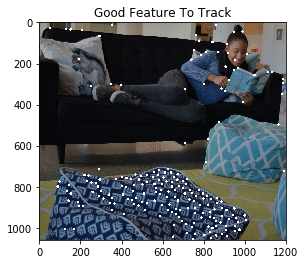

In [14]:
interestPoints = cv2.goodFeaturesToTrack(gray, maxCorners=200, qualityLevel=0.01, minDistance=20).reshape(-1, 2)
interestPointRegions = np.concatenate((interestPoints, np.ones(interestPoints.shape)), axis=1).astype(np.int32)
showImage('Good Feature To Track', drawRegions(img, faded.copy(), interestPointRegions, (255, 255, 255), size=10))

## Product Detection
Other times, we know a specific product is in an image and we want to make sure we don't crop it out. We can achieve this by localizing an image of the product in our image of interest.

In our example, the product is:

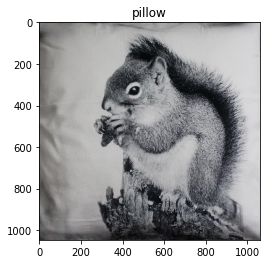

In [2]:
productImage = cv2.imread("product.jpg")
showImage('pillow', productImage)


We can locate the product in the image using instance retrieval techniques. First, we'll estimate the transformation between the product and the target image:

In [4]:
!pip install opencv-contrib-python==3.4.2.16

print("OpenCV version:")
print(cv2.__version__)

flann = cv2.FlannBasedMatcher({'algorithm': 0, 'trees': 8}, {'checks': 100})
# detector = cv2.SIFT()
detector = cv2.xfeatures2d.SIFT_create()
kpts1, descs1 = detector.detectAndCompute(productImage, None)
kpts2, descs2 = detector.detectAndCompute(img, None)
matches = [m for (m, n) in flann.knnMatch(descs1, descs2, k=2) if m.distance < 0.8 * n.distance]
sourcePoints = np.float32([kpts1[m.queryIdx].pt for m in matches]).reshape(-1, 2)
destPoints = np.float32([kpts2[m.trainIdx].pt for m in matches]).reshape(-1, 2)
M, mask = cv2.findHomography(sourcePoints, destPoints, cv2.RANSAC, 11.0)

OpenCV version:
3.4.2


The result is a set of correspondence points between the images:

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == '':


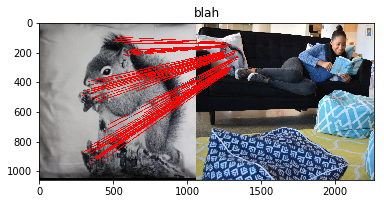

In [6]:
def drawMatches(img1, kpts1, img2, kpts2, matches):
    # combine both images
    out = np.zeros((max([img1.shape[0], img2.shape[0]]), img1.shape[1] + img2.shape[1], 3), dtype='uint8')
    out[: img1.shape[0], : img1.shape[1]] = img1
    out[: img2.shape[0], img1.shape[1]:] = img2
    # draw the lines
    for match in matches:
        (x1, y1) = kpts1[match.queryIdx].pt
        (x2, y2) = kpts2[match.trainIdx].pt
        cv2.line(out, (int(x1), int(y1)), (int(x2) + img1.shape[1], int(y2)), (0, 0, 255), 4)
    return out
showImage('blah', drawMatches(productImage, kpts1, img, kpts2, np.array(matches)[[np.where(mask.ravel() == 1)[0]]]))

We simply take the bounding box around the product's location:

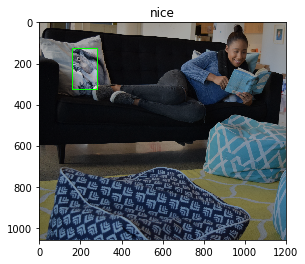

In [12]:
pp = destPoints[mask.ravel() == 1]
xmin = pp[:, 0].min()
ymin = pp[:, 1].min()
productRegions = np.array([xmin, ymin, pp[:, 0].max() - xmin, pp[:, 1].max() - ymin]).astype(np.int32).reshape(1, 4)
showImage('nice', drawRegions(img, faded.copy(), productRegions, (0, 255, 0)))

## Content Regions
In summary, we have detected faces, interest points, and products in the image. Together, these form the full set of content regions:

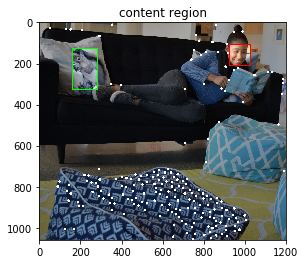

In [16]:
contentRectangles = np.concatenate((faceRegions, productRegions, interestPointRegions), axis=0)
vis = faded.copy()
drawRegions(img, vis, interestPointRegions, (255, 255, 255), size=10)
drawRegions(img, vis, faceRegions)
drawRegions(img, vis, productRegions, (0, 255, 0))
showImage('content region', vis)

# Optimal Cropping
Now that we have detected the content regions in the image, we'd like to identify the best way to crop the image to a desired aspect ratio of `1.91`. The strategy is simple: find the area of the image with the desired aspect ratio containing the highest sum of the content rectangle scores.

First, let's assign a score to each content rectangle. For this example, we'll just use the area of each rectangle.

In [17]:
contentScores = np.multiply(contentRectangles[:, 2], contentRectangles[:, 3])

## Reducing to One Dimension
Now for the fun part:
Depending on the input image and desired aspect ratio, the resulting crop will either have the same height as the input image and a reduced width, or the same width as the input image and a reduced height. The *principal axis* is the dimension of the input image that needs to be cropped. Let:

In [18]:
alpha = img.shape[1] / float(img.shape[0])

be the aspect ratio of the input image. If `alpha > desiredAspectRatio`, then the horizontal axis is the principal axis and the system crops the width of the image. Similarly, if `alpha < desiredAspectRatio`, then the vertical axis is the principal axis and the system crops the height of the image.

Projecting the content rectangles onto the principal axis simplifies our goal: the optimal crop is simply the window along the principal axis containing the highest sum of content region scores. The length of this window is the size of the final crop along the principal axis.

In [21]:
if (alpha > desiredAspectRatio):  # the horizontal axis is the principal axis.
    finalWindowLength = int(desiredAspectRatio * img.shape[0])
    projection = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
else:  # the vertical axis is the principal axis.
    finalWindowLength = int(img.shape[1] / desiredAspectRatio)
    projection = np.array([[0, 1, 0, 0], [0, 0, 0, 1]])
contentRegions = np.dot(projection, contentRectangles.T).T

Thus, the content rectangles are reduced from two dimensional rectangles to one dimensional regions.

## Selecting the Optimal Crop

The optimal crop is the window of length `finalWindowLength` whose `contentRegions`' scores sum to the largest possible value. We can use a sliding window approach to quickly and efficiently find such a crop.

First, we'll define the *inflection points* for the sliding window approach. Each inflection point is a location on the number line where the value of the current window can change. There are two inflection points for each content region: one that removes the content region's score when the window passes the region's starting location, and one that adds a content region's score when the window encapsulates it.

In [22]:
inflectionPoints = np.concatenate((contentRegions[:, 0], contentRegions[:, 0] + contentRegions[:, 1] - finalWindowLength))
inflectionDeltas = np.concatenate((-contentScores, contentScores))
inflections = np.concatenate((inflectionPoints.reshape(-1, 1), inflectionDeltas.reshape(-1, 1)), axis=1)

Next, we'll sort the inflection points by their locations on the number line, and ignore any outside the valid range:

In [23]:
inflections = inflections[inflections[:, 0].argsort()]  # Sort by location
inflections = inflections[inflections[:, 0] >= 0]  # drop any outside our range

To implement our sliding window algorithm, we need only accumulate the sum of the inflection points' values at each location, and then take the maximum:

In [24]:
inflections[:, 1] = np.cumsum(inflections[:, 1])
optimalInflectionPoint = max(enumerate(inflections), key=lambda (idx, (s, v)): v)[0]

The `optimalInflectionPoint` contains a starting location that has the most value. In fact the range of pixels between that inflection point and the next one all have that same value. We'll take the middle of that range for our starting point:

In [25]:
optimalStartingLocation = (inflections[optimalInflectionPoint, 0] + inflections[optimalInflectionPoint + 1, 0]) / 2

Now that we know where the optimal crop begins on the principal axis, we can un-project it to get the final crop:

In [26]:
if alpha > desiredAspectRatio:
    optimalCrop = [optimalStartingLocation, 0, finalWindowLength, img.shape[0]]
else:
    optimalCrop = [0, optimalStartingLocation, img.shape[1], finalWindowLength]

Awesome! Now we know where to crop the image! You can see below that the optimal crop indeed includes the product, the face, and a large number of the interest points:

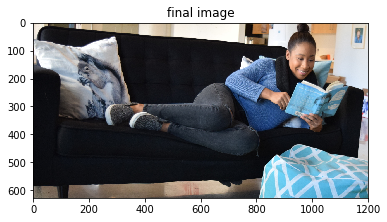

In [28]:
result = img[optimalCrop[1]: optimalCrop[3] + optimalCrop[1], optimalCrop[0]: optimalCrop[2] + optimalCrop[0]]
showImage('final image', result)

Now that's a good pic!

Disclaimer: The code above is meant as a demonstration. Optimization, handling of edge cases, and parameter tuning are left as an exercise for the reader 😉.

# Result Gallery
Below are some example results. The desired aspect ratio is listed below the input image.
![](./results.png)

# Uses in Curalate Products

One great place we use intelligent cropping is when displaying our clients' images. Below is a screenshot showing some product images before intelligent cropping, and then after. Notice how the models' faces, the shoe, and the bag were all cropped using the naive method. After intelligent cropping, our thumbnails are much more useful representations of the original images.

|Before Intelligent Cropping | After Intelligent Cropping|
|----|----|
|![](./curalate-before.png)|![](./curalate-after.png)|